### Importing the libraries and data

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
#from keras import models, layers, optimizers, regularizers, callbacks
#from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

# Read all the preprocessed data

In [2]:
pd.set_option("display.max_columns", 500)

In [3]:
df_amsterdam = pd.read_csv("amsterdam_cleaned_v2.csv.gz")
df_amsterdam["gdp_city"] = 172

In [4]:
df_paris = pd.read_csv("paris_cleaned_v2.csv.gz")
df_paris["gdp_city"] = 685

In [5]:
df_berlin = pd.read_csv("berlin_cleaned_v2.csv.gz")
df_berlin["gdp_city"] = 184

In [6]:
df_london = pd.read_csv("london_cleaned_v2.csv.gz")
df_london["gdp_city"] = 801

# Create a master dataset comprising of Amsterdam, Berlin and Paris

In [7]:
df = pd.concat([df_amsterdam,df_berlin,df_paris]).reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108875 entries, 0 to 108874
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           108875 non-null  int64  
 1   experiences_offered          108875 non-null  object 
 2   host_response_time           108875 non-null  object 
 3   host_response_rate           108875 non-null  object 
 4   host_is_superhost            108875 non-null  float64
 5   host_listings_count          108875 non-null  float64
 6   host_identity_verified       108875 non-null  float64
 7   borough                      108875 non-null  object 
 8   city                         108844 non-null  object 
 9   country                      108875 non-null  object 
 10  property_type                108875 non-null  object 
 11  room_type                    108875 non-null  object 
 12  accommodates                 108875 non-null  int64  
 13 

In [9]:
df.drop(columns=["id","borough","amenities","city","country"], inplace=True)
df_london.drop(columns=["id","borough","amenities","city","country"], inplace=True)

In [10]:
df.fillna("unkown", inplace=True)
df_london.fillna("unkown", inplace=True)

In [11]:
common_columns = list(set(df.columns) & set(df_london.columns))
df= df[common_columns]
df_london = df_london[common_columns]

In [12]:
df[df.columns[df.dtypes == object]] = df[df.columns[df.dtypes == object]].astype('str')
df_london[df_london.columns[df_london.dtypes == object]] = df_london[df_london.columns[df_london.dtypes == object]].astype('str')

# Log Transformation of Price

In [13]:
df["price"] = df["price"].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
df["price"] = np.log(df["price"])
df_london["price"] = df_london["price"].astype('float64').replace(0.0, 0.01)
df_london["price"] = np.log(df_london["price"])

In [14]:
df.shape

(108875, 64)

# Remove Outlier

In [15]:
def remove_outliers(df):
    data_mean, data_std = np.mean(df.price), np.std(df.price)
    bounds = 3* data_std
    df["price"].hist()
    print(data_mean)
    print(data_std)
    indexNames = df[(df['price'] > (data_mean + bounds)) | (df['price'] < (data_mean - bounds))].index
    print(len(indexNames))
    df.drop(indexNames , inplace=True)
    return df

4.453287128200538
0.7076606337718425
1070


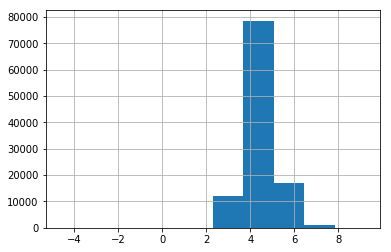

In [16]:
df = remove_outliers(df)

In [17]:
df.shape

(107805, 64)

4.427942435173755
0.7949462587665764
583


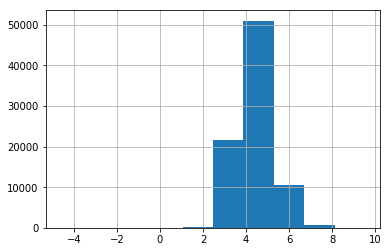

In [18]:
df_london = remove_outliers(df_london)

In [19]:
df_london.shape

(83259, 64)

# Remove Correlated features

In [20]:
subset_feature = df.columns.to_list()

In [21]:
subset_feature.remove("price")

In [22]:
correlated_features = set()
correlation_matrix = df[subset_feature].corr()

In [23]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

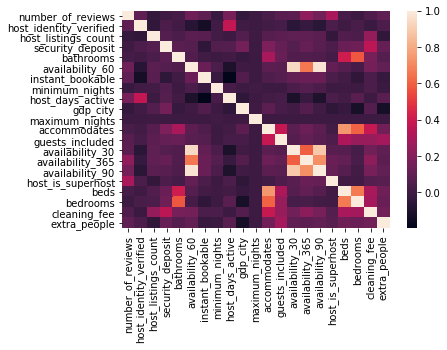

In [24]:
sns.heatmap(df[subset_feature].corr(), annot=False)

In [25]:
print(correlated_features)

{'availability_30', 'availability_90', 'beds'}


In [26]:
df.drop(labels=correlated_features, axis=1, inplace=True)
df_london.drop(labels=correlated_features, axis=1, inplace=True)

In [27]:
df.shape

(107805, 61)

In [28]:
df_london.shape

(83259, 61)

# Encoding of Categorical variables

In [29]:
from sklearn.preprocessing import LabelEncoder

Remove fields of low variance

In [30]:
df.experiences_offered.value_counts()

none    107805
Name: experiences_offered, dtype: int64

In [31]:
df.drop(columns=["experiences_offered"], inplace=True)
df_london.drop(columns=["experiences_offered"], inplace=True)

In [32]:
df_london.cancellation_policy.replace({
    'luxury_super_strict_95': 'strict_14_with_grace_period'
    }, inplace=True)

In [33]:
categorical_columns = []
categorical_dims =  {}
for col in df.columns[df.dtypes == object]:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    df_london[col] = l_enc.transform(df_london[col].values)
    categorical_dims[col] = len(l_enc.classes_)

pets_allowed 2
review_scores_cleanliness 5
secure 2
accessible 2
private_entrance 2
white_goods 2
bed_linen 2
review_scores_rating 5
cooking_basics 2
balcony 2
review_scores_location 5
review_scores_checkin 5
room_type 4
review_scores_communication 5
air_conditioning 2
check_in_24h 2
coffee_machine 2
hot_tub_sauna_or_pool 2
parking 2
high_end_electronics 2
elevator 2
internet 2
host_response_time 5
tv 2
cancellation_policy 3
long_term_stays 2
bbq 2
bed_type 5
breakfast 2
nature_and_views 2
review_scores_accuracy 5
gym 2
host_greeting 2
property_type 4
review_scores_value 5
child_friendly 2
self_check_in 2
host_response_rate 6
outdoor_space 2
event_suitable 2
smoking_allowed 2


In [34]:
categorical_dims

{'pets_allowed': 2,
 'review_scores_cleanliness': 5,
 'secure': 2,
 'accessible': 2,
 'private_entrance': 2,
 'white_goods': 2,
 'bed_linen': 2,
 'review_scores_rating': 5,
 'cooking_basics': 2,
 'balcony': 2,
 'review_scores_location': 5,
 'review_scores_checkin': 5,
 'room_type': 4,
 'review_scores_communication': 5,
 'air_conditioning': 2,
 'check_in_24h': 2,
 'coffee_machine': 2,
 'hot_tub_sauna_or_pool': 2,
 'parking': 2,
 'high_end_electronics': 2,
 'elevator': 2,
 'internet': 2,
 'host_response_time': 5,
 'tv': 2,
 'cancellation_policy': 3,
 'long_term_stays': 2,
 'bbq': 2,
 'bed_type': 5,
 'breakfast': 2,
 'nature_and_views': 2,
 'review_scores_accuracy': 5,
 'gym': 2,
 'host_greeting': 2,
 'property_type': 4,
 'review_scores_value': 5,
 'child_friendly': 2,
 'self_check_in': 2,
 'host_response_rate': 6,
 'outdoor_space': 2,
 'event_suitable': 2,
 'smoking_allowed': 2}

In [35]:
df_london

,number_of_reviews,pets_allowed,host_identity_verified,host_listings_count,price,review_scores_cleanliness,secure,accessible,private_entrance,white_goods,security_deposit,bed_linen,review_scores_rating,cooking_basics,balcony,bathrooms,review_scores_location,review_scores_checkin,room_type,availability_60,review_scores_communication,air_conditioning,check_in_24h,coffee_machine,instant_bookable,hot_tub_sauna_or_pool,parking,minimum_nights,high_end_electronics,host_days_active,elevator,internet,host_response_time,tv,gdp_city,cancellation_policy,long_term_stays,maximum_nights,accommodates,guests_included,bbq,availability_365,bed_type,breakfast,nature_and_views,review_scores_accuracy,gym,host_greeting,property_type,host_is_superhost,review_scores_value,child_friendly,self_check_in,host_response_rate,bedrooms,outdoor_space,cleaning_fee,extra_people,event_suitable,smoking_allowed
0,185,1,1.0,3.0,4.477337,3,1,1,1,0,400,1,2,1,1,1.0,3,1,0,42,1,1,1,1,1,1,0,4,1,3634.0,1,0,4,0,801,2,0,180,4,2,1,344,4,1,1,3,1,1,0,1.0,3,0,0,1,1.0,1,30,20,1,1
1,19,1,0.0,4.0,4.174387,1,1,0,1,0,100,0,3,0,0,1.0,3,1,2,53,1,1,1,0,0,1,0,1,1,3590.0,1,0,4,0,801,1,0,29,2,1,1,358,4,1,1,1,1,0,0,0.0,3,0,1,1,1.0,1,15,15,1,0
2,88,1,1.0,1.0,4.605170,1,1,1,1,0,150,1,3,1,1,1.0,1,1,0,0,1,0,0,0,1,1,1,30,1,3571.0,1,0,3,0,801,2,0,50,2,2,1,137,4,1,1,1,1,1,0,0.0,3,1,1,1,1.0,1,50,0,1,1
3,41,1,1.0,18.0,5.703782,3,1,1,1,0,350,0,2,0,1,2.0,1,3,0,27,3,1,1,0,1,1,0,3,1,3541.0,0,0,4,0,801,2,0,365,6,4,1,252,4,1,1,1,1,1,0,0.0,3,0,0,4,3.0,1,65,10,1,1
4,34,1,0.0,1.0,4.174387,1,1,1,1,0,250,1,2,1,1,1.0,3,3,0,42,1,1,1,1,1,1,0,90,1,3452.0,0,0,4,0,801,1,1,1125,4,2,1,134,4,1,1,1,1,0,0,1.0,3,1,1,1,2.0,1,50,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83837,0,1,0.0,0.0,4.787492,4,1,1,1,0,0,1,4,1,1,1.0,4,4,2,16,4,1,1,1,1,1,1,2,1,1047.0,1,1,1,1,801,0,1,1125,1,1,1,19,4,1,1,4,1,1,2,0.0,4,1,1,5,1.0,1,0,0,1,1
83838,0,1,0.0,7.0,6.013715,4,1,1,0,0,0,1,4,1,1,1.0,4,4,0,57,4,1,1,1,1,1,1,1,1,296.0,1,0,4,0,801,1,1,1125,11,2,1,86,4,1,1,4,1,1,2,0.0,4,1,1,4,4.0,1,45,15,1,1
83839,0,1,0.0,0.0,5.703782,4,1,1,1,0,0,1,4,1,1,2.0,4,4,0,0,4,1,1,1,0,1,1,7,1,449.0,0,0,4,0,801,2,1,1125,5,1,1,89,4,0,1,4,1,1,0,0.0,4,1,1,1,3.0,1,0,0,1,1
83840,0,1,0.0,11.0,4.700480,4,1,1,1,0,250,0,4,0,1,1.0,4,4,0,46,4,1,1,1,1,1,0,3,1,1474.0,1,0,4,0,801,2,1,365,6,2,1,334,4,1,1,4,1,1,0,0.0,4,1,1,4,2.0,1,70,15,1,1


In [36]:
target = 'price'

features = [ col for col in df.columns if col not in [target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [37]:
cat_emb_dim = np.array(cat_dims)//2

In [38]:
cat_emb_dim = cat_emb_dim.tolist()

# Tabnet

In [39]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [40]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs,gamma=1.5, lambda_sparse = 0.000001, device_name="cuda")

Device used : cpu


In [41]:
max_epochs = 50

In [42]:
df.reset_index(drop=True, inplace=True)

In [43]:
target = 'price'
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train","test"], p =[.8, .2], size=(df.shape[0],))

train_indices = df[df.Set=="train"].index
test_indices = df[df.Set=="test"].index

In [44]:
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices].reshape(-1, 1)

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices].reshape(-1, 1)

X_london = df_london[features].values
y_london = df_london[target].values.reshape(-1, 1)

In [45]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024
)

epoch 0  | loss: 1.59345 | train_mse: 0.41978 | valid_mse: 0.42659 |  0:00:28s
epoch 1  | loss: 0.28749 | train_mse: 0.30836 | valid_mse: 0.3094  |  0:00:57s
epoch 2  | loss: 0.24215 | train_mse: 0.26698 | valid_mse: 0.26838 |  0:01:25s
epoch 3  | loss: 0.21785 | train_mse: 0.23867 | valid_mse: 0.2439  |  0:01:55s
epoch 4  | loss: 0.2122  | train_mse: 0.20211 | valid_mse: 0.20839 |  0:02:24s
epoch 5  | loss: 0.20365 | train_mse: 0.19834 | valid_mse: 0.20123 |  0:02:54s
epoch 6  | loss: 0.19573 | train_mse: 0.19103 | valid_mse: 0.19283 |  0:03:23s
epoch 7  | loss: 0.18959 | train_mse: 0.18502 | valid_mse: 0.18965 |  0:03:53s
epoch 8  | loss: 0.18519 | train_mse: 0.18306 | valid_mse: 0.18571 |  0:04:23s
epoch 9  | loss: 0.18221 | train_mse: 0.17527 | valid_mse: 0.18133 |  0:04:53s
epoch 10 | loss: 0.17871 | train_mse: 0.17328 | valid_mse: 0.17921 |  0:05:25s
epoch 11 | loss: 0.1736  | train_mse: 0.17287 | valid_mse: 0.17718 |  0:05:55s
epoch 12 | loss: 0.17194 | train_mse: 0.16683 | vali

In [46]:
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.1421
Validation MSE: 0.1481

Training r2: 0.6675
Validation r2: 0.6583


In [47]:
preds = clf.predict(X_london)

y_true = y_london

print("Validation London MSE:", round(mean_squared_error(y_london, preds),4))
print("Validation London r2:", round(r2_score(y_london, preds),4))

Validation London MSE: 0.2107
Validation London r2: 0.6253


In [48]:
clf.feature_importances_

array([1.67150712e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.40103447e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.93482876e-06, 2.03160485e-07, 3.67302458e-03,
       1.73991016e-06, 0.00000000e+00, 8.05831895e-03, 7.54321000e-10,
       6.79198764e-07, 7.92604442e-02, 2.54304966e-02, 0.00000000e+00,
       4.50830152e-02, 0.00000000e+00, 0.00000000e+00, 3.38955780e-02,
       1.35947295e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.18804863e-02, 1.62405506e-05, 3.39955442e-07,
       1.23081911e-07, 6.90367488e-02, 3.77923179e-03, 0.00000000e+00,
       6.38697831e-04, 2.14748345e-01, 0.00000000e+00, 1.80810657e-06,
       0.00000000e+00, 1.68660549e-06, 0.00000000e+00, 1.82474880e-03,
       0.00000000e+00, 2.43350142e-05, 0.00000000e+00, 2.64318144e-08,
       0.00000000e+00, 0.00000000e+00, 9.23876750e-06, 0.00000000e+00,
       1.20576701e-01, 2.76516733e-01, 0.00000000e+00, 2.10501122e-06,
      

In [81]:
feature = pd.DataFrame(clf.feature_importances_, columns=['weight'], index=features)
feature.sort_values('weight', inplace=True)

In [82]:
feature

,weight
smoking_allowed,0.000000e+00
availability_365,0.000000e+00
check_in_24h,0.000000e+00
coffee_machine,0.000000e+00
host_is_superhost,0.000000e+00
parking,0.000000e+00
minimum_nights,0.000000e+00
review_scores_communication,0.000000e+00
high_end_electronics,0.000000e+00
event_suitable,0.000000e+00


In [87]:
feature[-10:-1]

,weight
elevator,0.021880
availability_60,0.025430
instant_bookable,0.033896
air_conditioning,0.045083
gdp_city,0.069037
room_type,0.079260
review_scores_cleanliness,0.094010
host_response_rate,0.120577
accommodates,0.214748


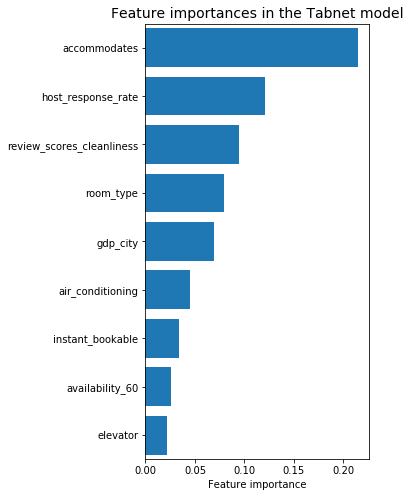

In [92]:
# Plotting feature importances
plt.figure(figsize=(4,8))
plt.barh(feature[-10:-1].index, feature[-10:-1].weight, align='center') 
plt.title("Feature importances in the Tabnet model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [52]:
explain_matrix, masks = clf.explain(X_london)

In [53]:
from matplotlib import pyplot as plt
%matplotlib inline

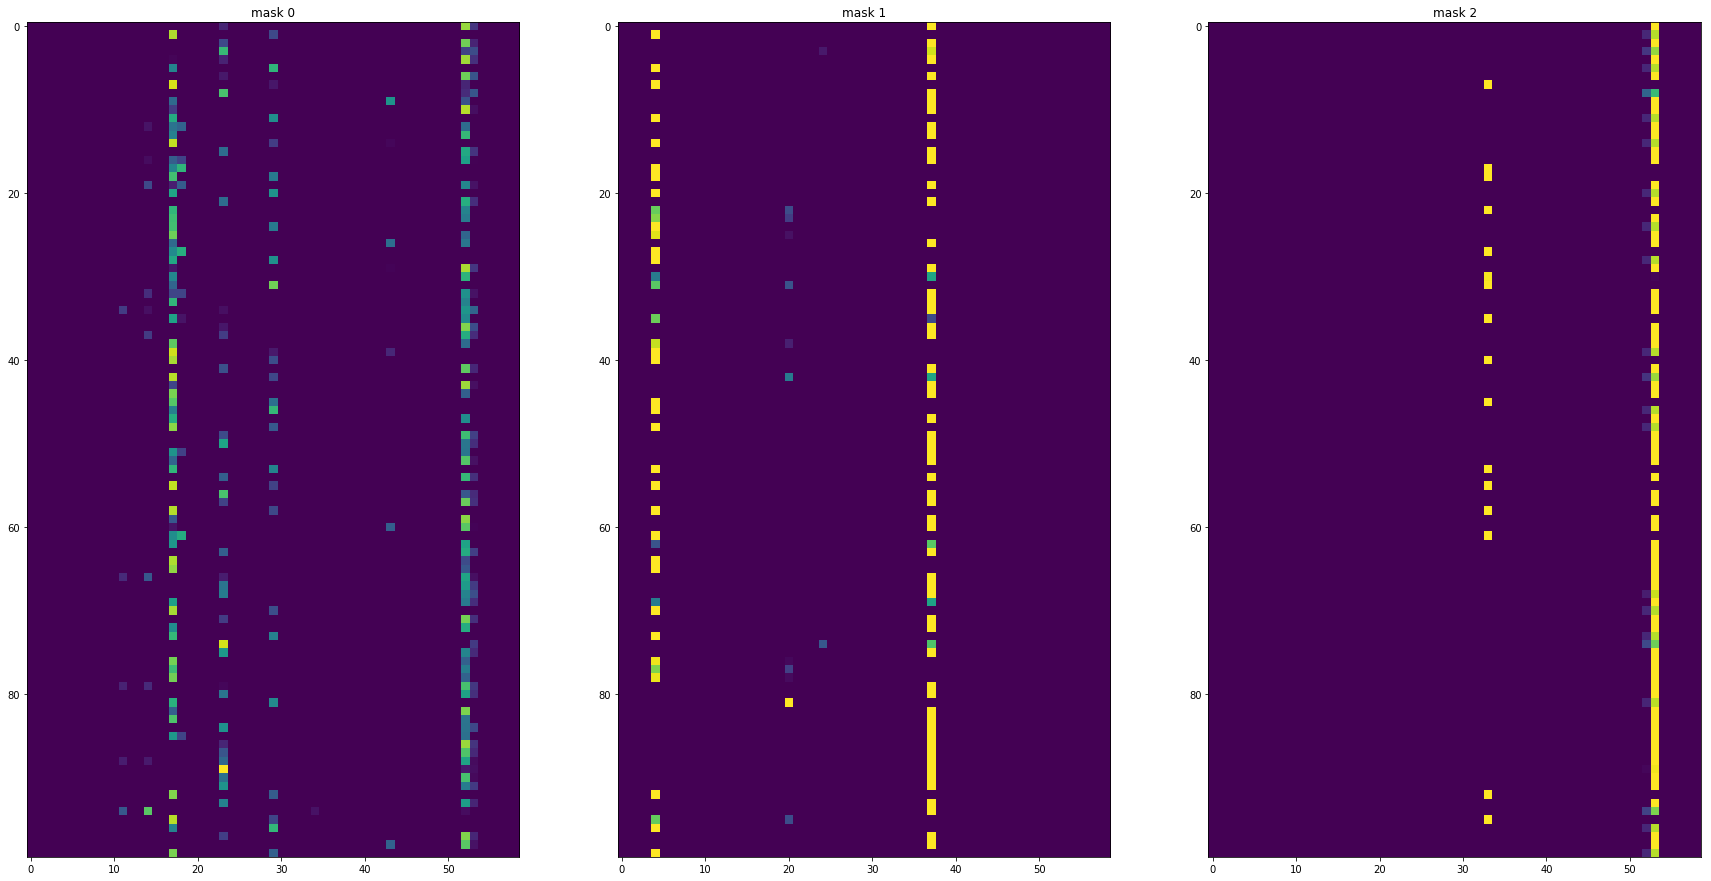

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(30,30))

for i in range(3):
    axs[i].imshow(masks[i][:100])
    axs[i].set_title(f"mask {i}")

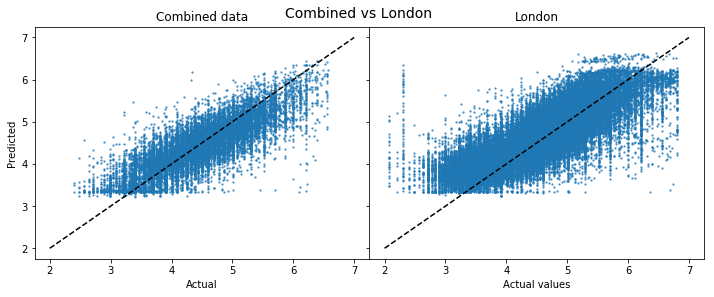

In [59]:
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Combined vs London', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred, s=2, alpha=0.6)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Combined data')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
    
ax2.scatter(y_london, preds, s=2, alpha=0.6)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('London')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
    
plt.show()

In [60]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=10,
    learning_rate=0.01,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=80,
        verbose=10)

[0]	validation_0-rmse:3.94914
Will train until validation_0-rmse hasn't improved in 80 rounds.
[10]	validation_0-rmse:3.57611
[20]	validation_0-rmse:3.23918
[30]	validation_0-rmse:2.93468
[40]	validation_0-rmse:2.65973
[50]	validation_0-rmse:2.4115
[60]	validation_0-rmse:2.18736
[70]	validation_0-rmse:1.9853
[80]	validation_0-rmse:1.80302
[90]	validation_0-rmse:1.63888
[100]	validation_0-rmse:1.49114
[110]	validation_0-rmse:1.35816
[120]	validation_0-rmse:1.23867
[130]	validation_0-rmse:1.13144
[140]	validation_0-rmse:1.03533
[150]	validation_0-rmse:0.949365
[160]	validation_0-rmse:0.872608
[170]	validation_0-rmse:0.804114
[180]	validation_0-rmse:0.743171
[190]	validation_0-rmse:0.689134
[200]	validation_0-rmse:0.64135
[210]	validation_0-rmse:0.599305
[220]	validation_0-rmse:0.562331
[230]	validation_0-rmse:0.529998
[240]	validation_0-rmse:0.501794
[250]	validation_0-rmse:0.477388
[260]	validation_0-rmse:0.456319
[270]	validation_0-rmse:0.438188
[280]	validation_0-rmse:0.422652
[290]	v

XGBRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000, n_jobs=-1,
             subsample=0.7, verbosity=0)

In [61]:
preds = clf_xgb.predict(X_london)

print("Validation London MSE:", round(mean_squared_error(y_london, preds),4))
print("Validation London r2:", round(r2_score(y_london, preds),4))

Validation London MSE: 0.2083
Validation London r2: 0.6295


In [62]:
y_test_pred = clf_xgb.predict(X_test)
y_train_pred = clf_xgb.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.0646
Validation MSE: 0.109

Training r2: 0.8488
Validation r2: 0.7486


In [93]:
ft_weights_xgb_reg = pd.DataFrame(clf_xgb.feature_importances_, columns=['weight'], index=features)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
host_identity_verified,0.001999
pets_allowed,0.002280
number_of_reviews,0.002440
accessible,0.002498
bed_linen,0.002765
review_scores_checkin,0.002804
review_scores_communication,0.002917
secure,0.002939
cooking_basics,0.003026
review_scores_accuracy,0.003193


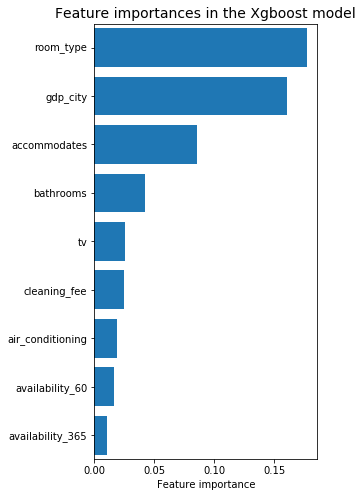

In [96]:
# Plotting feature importances
plt.figure(figsize=(4,8))
plt.barh(ft_weights_xgb_reg[-10:-1].index, ft_weights_xgb_reg[-10:-1].weight, align='center') 
plt.title("Feature importances in the Xgboost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

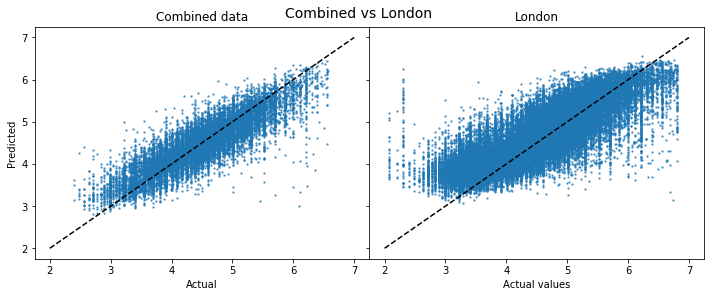

In [65]:
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Combined vs London', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred, s=2, alpha=0.6)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Combined data')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
    
ax2.scatter(y_london, preds, s=2, alpha=0.6)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('London')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
    
plt.show()

In [66]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

C:\Users\Divyam\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=0)

In [67]:
y_test_pred = regr.predict(X_test)
y_train_pred = regr.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.0167
Validation MSE: 0.1216

Training r2: 0.9609
Validation r2: 0.7195


In [68]:
preds = regr.predict(X_london)


print("Validation London MSE:", round(mean_squared_error(y_london, preds),4))
print("Validation London r2:", round(r2_score(y_london, preds),4))

Validation London MSE: 0.235
Validation London r2: 0.5821


In [69]:
ft_weights_xgb_reg = pd.DataFrame(regr.feature_importances_, columns=['weight'], index=features)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
high_end_electronics,0.000482
bbq,0.000585
gym,0.000743
nature_and_views,0.000755
outdoor_space,0.001005
hot_tub_sauna_or_pool,0.001161
accessible,0.001249
event_suitable,0.001465
self_check_in,0.001639
bed_type,0.001676


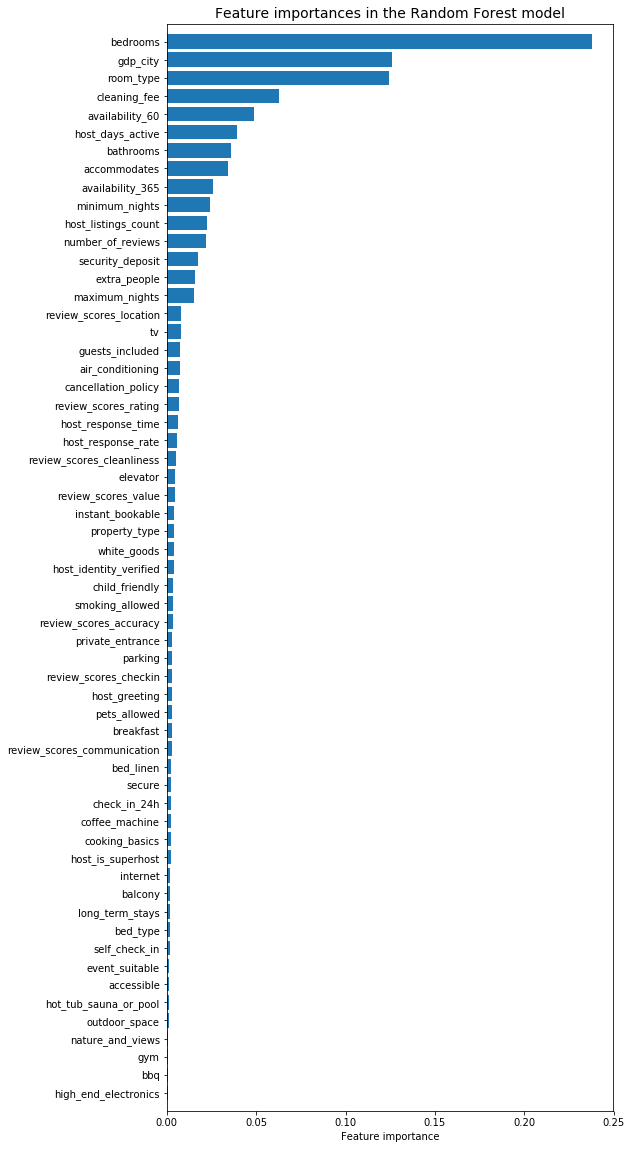

In [70]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the Random Forest model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

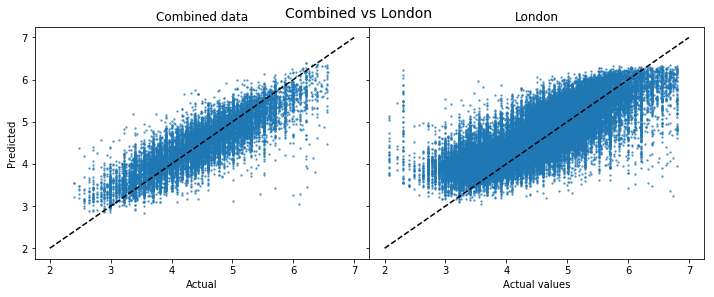

In [71]:
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Combined vs London', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred, s=2, alpha=0.6)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Combined data')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
    
ax2.scatter(y_london, preds, s=2, alpha=0.6)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('London')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
    
plt.show()

In [75]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0)
regr.fit(X_train, y_train)

C:\Users\Divyam\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostRegressor(random_state=0)

In [76]:
y_test_pred = regr.predict(X_test)
y_train_pred = regr.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.213
Validation MSE: 0.2183

Training r2: 0.5015
Validation r2: 0.4964


In [77]:
preds = regr.predict(X_london)
print("Validation London MSE:", round(mean_squared_error(y_london, preds),4))
print("Validation London r2:", round(r2_score(y_london, preds),4))

Validation London MSE: 0.3325
Validation London r2: 0.4087


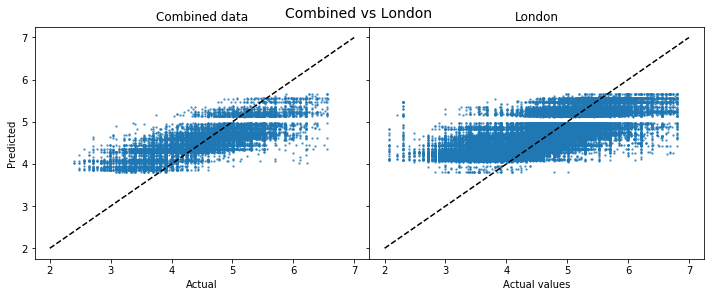

In [78]:
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Combined vs London', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred, s=2, alpha=0.6)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Combined data')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
    
ax2.scatter(y_london, preds, s=2, alpha=0.6)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('London')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
    
plt.show()